In [1]:
#importing all the libraires and dependencies
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
# Function to load and process an image
def load_and_process_image(image_path, max_dim=256):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    return image


In [3]:
# Function to display content, style, and generated images
def display_images(content_image, style_image, generated_image):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(tf.squeeze(content_image, axis=0))
    plt.title('Content Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(style_image, axis=0))
    plt.title('Style Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(generated_image, axis=0))
    plt.title('Generated Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
# Function to compute the Gram matrix
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


In [5]:
# Total variation loss function for smoothness
def total_variation_loss(image):
    x_deltas = image[:, 1:, :, :] - image[:, :-1, :, :]
    y_deltas = image[:, :, 1:, :] - image[:, :, :-1, :]
    return tf.reduce_mean(tf.square(x_deltas)) + tf.reduce_mean(tf.square(y_deltas))


In [6]:
# Model class to extract style and content features from the VGG19 network
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = self._vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def _vgg_layers(self, layer_names):
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in layer_names]
        model = tf.keras.Model([vgg.input], outputs)
        return model

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [7]:

# StyleTransfer class for managing the entire process
class StyleTransfer:
    def __init__(self, style_layers, content_layers):
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.extractor = StyleContentModel(style_layers, content_layers)
        self.style_targets = None
        self.content_targets = None
        self.image = None
        self.opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

    def set_images(self, content_image, style_image):
        self.content_image = load_and_process_image(content_image)
        self.style_image = load_and_process_image(style_image)
        self.style_targets = self.extractor(self.style_image)['style']
        self.content_targets = self.extractor(self.content_image)['content']
        self.image = tf.Variable(self.content_image)

    @tf.function()
    def train_step(self, style_weight, content_weight, tv_weight, num_style_layers, num_content_layers):
        with tf.GradientTape() as tape:
            outputs = self.extractor(self.image)
            loss = self.style_content_loss(outputs, style_weight, content_weight, tv_weight, num_style_layers, num_content_layers)

        grad = tape.gradient(loss, self.image)
        self.opt.apply_gradients([(grad, self.image)])
        self.image.assign(tf.clip_by_value(self.image, 0.0, 1.0))
        return loss

    def style_content_loss(self, outputs, style_weight, content_weight, tv_weight, num_style_layers, num_content_layers):
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - self.style_targets[name])**2)
                                    for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - self.content_targets[name])**2)
                                      for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers

        # Total variation loss
        tv_loss = tv_weight * total_variation_loss(self.image)

        total_loss = style_loss + content_loss + tv_loss
        return total_loss

    def generate_image(self, steps, style_weight, content_weight, tv_weight, num_style_layers, num_content_layers):
        for i in range(steps):
            loss = self.train_step(style_weight, content_weight, tv_weight, num_style_layers, num_content_layers)
            if i % 20 == 0:
                print(f"Step {i}, Loss: {loss.numpy()}")

    def display_result(self):
        display_images(self.content_image, self.style_image, self.image.read_value())

    def save_image(self, file_path):
        image = tf.squeeze(self.image, axis=0)
        image = tf.image.convert_image_dtype(image, tf.uint8)
        encoded_image = tf.image.encode_jpeg(image)
        tf.io.write_file(file_path, encoded_image)

In [8]:
# Function to run the style transfer process
def run_style_transfer(content_image_path, style_image_path, output_image_path):
    start_time = time.time()
    
    # Define content and style layers from VGG19
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    # Initialize StyleTransfer object
    style_transfer = StyleTransfer(style_layers, content_layers)

    # Set content and style images
    style_transfer.set_images(content_image_path, style_image_path)

    # Generate and display the image
    style_transfer.generate_image(steps=200, style_weight=1e-2, content_weight=1e4, tv_weight=10,
                                  num_style_layers=num_style_layers, num_content_layers=num_content_layers)
    style_transfer.display_result()

    # Save the generated image
    style_transfer.save_image(output_image_path)

    # Calculate and print total time taken
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total time taken: {total_time} seconds")


Step 0, Loss: 3486688256.0
Step 20, Loss: 882227968.0
Step 40, Loss: 497000320.0
Step 60, Loss: 334837120.0
Step 80, Loss: 250891904.0
Step 100, Loss: 208583792.0
Step 120, Loss: 182872160.0
Step 140, Loss: 158420896.0
Step 160, Loss: 141864000.0
Step 180, Loss: 129487152.0


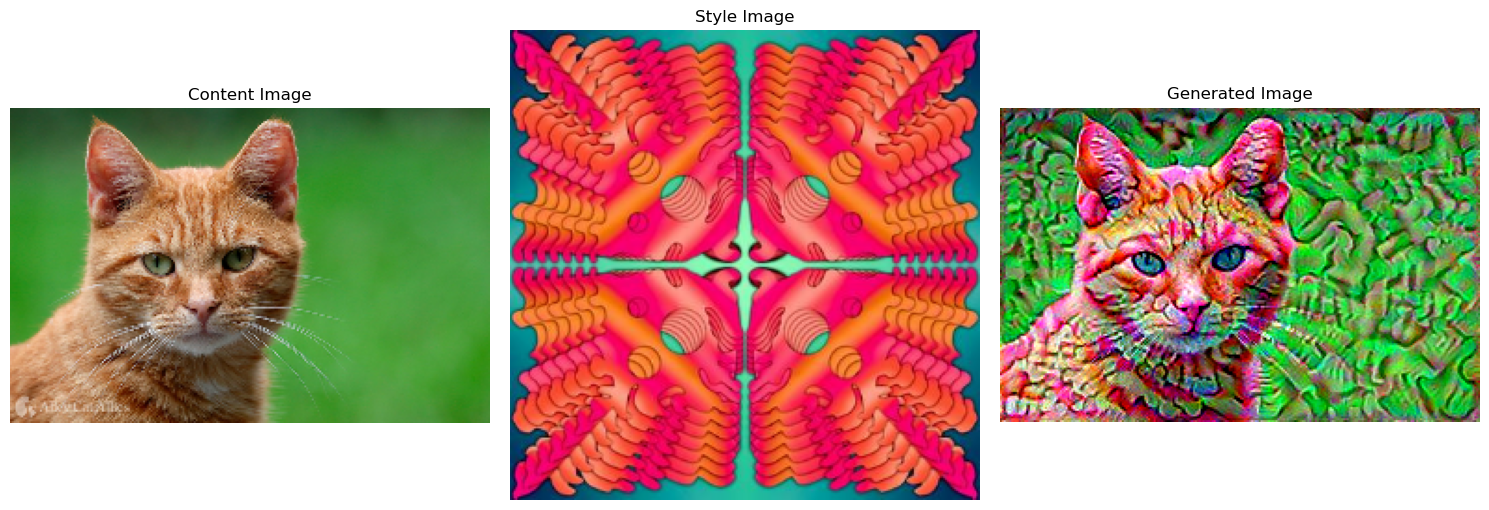

Total time taken: 353.0120916366577 seconds


In [9]:
# Example usage:
content_path = "images/content1.jpg"  ##content image path
style_path = "images/style1.jpg"        ## style image path
output_path = "OutputImages/generated_image1.jpeg"    ## path where you want to save generated image
run_style_transfer(content_path, style_path, output_path)

Step 0, Loss: 2152244224.0
Step 20, Loss: 687374016.0
Step 40, Loss: 410870432.0
Step 60, Loss: 283033024.0
Step 80, Loss: 214841696.0
Step 100, Loss: 166774336.0
Step 120, Loss: 133338104.0
Step 140, Loss: 110189120.0
Step 160, Loss: 94215184.0
Step 180, Loss: 82746992.0


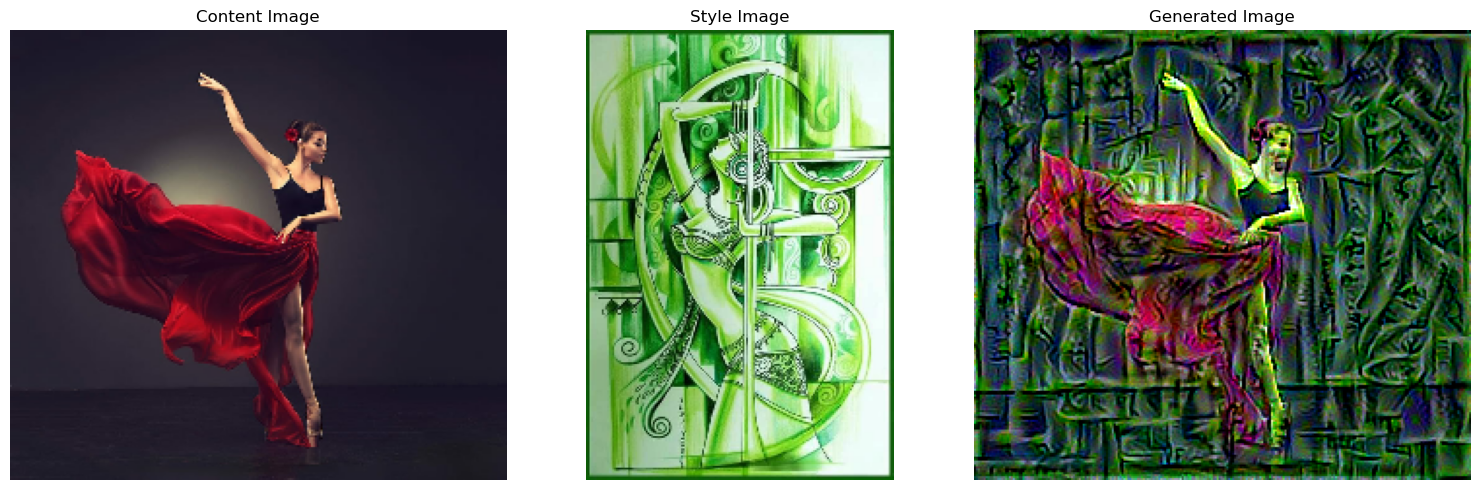

Total time taken: 467.6735038757324 seconds


In [10]:
# Example usage:
content_path = "images/content2.jpg"  ##content image path
style_path = "images/style2.jpg"        ## style image path
output_path = "OutputImages/generated_image2.jpeg"    ## path where you want to save generated image
run_style_transfer(content_path, style_path, output_path)

Step 0, Loss: 745838464.0
Step 20, Loss: 155590384.0
Step 40, Loss: 88037104.0
Step 60, Loss: 61157244.0
Step 80, Loss: 51051600.0
Step 100, Loss: 44582728.0
Step 120, Loss: 39724604.0
Step 140, Loss: 36013856.0
Step 160, Loss: 33167704.0
Step 180, Loss: 30876276.0


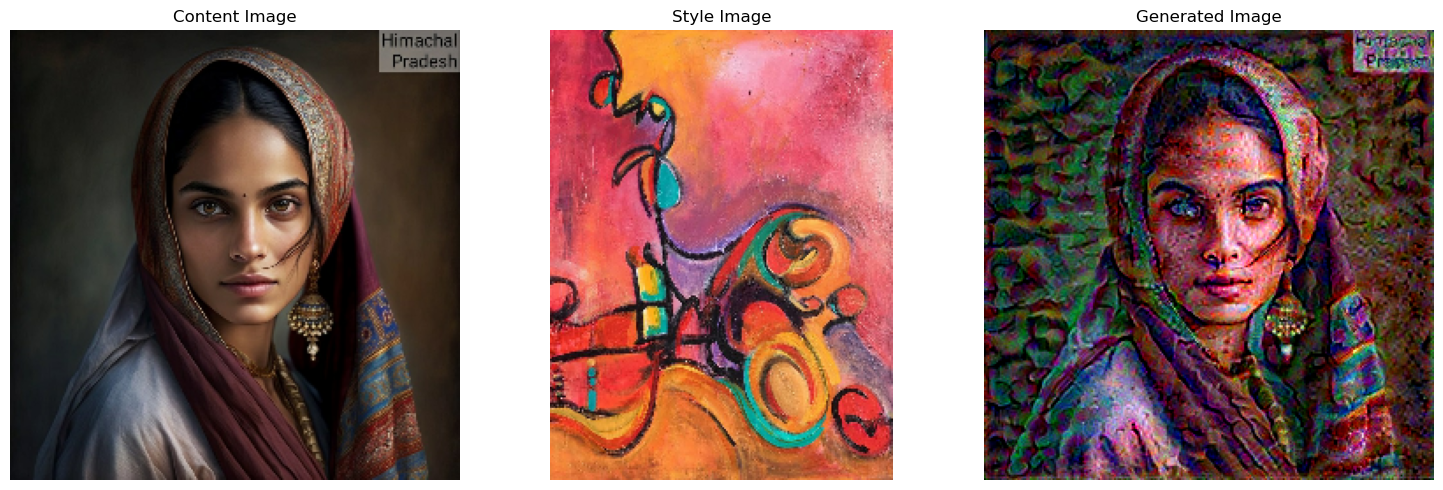

Total time taken: 538.757611989975 seconds


In [11]:
# Example usage:
content_path = "images/content3.jpg"  ##content image path
style_path = "images/style3.jpg"        ## style image path
output_path = "OutputImages/generated_image3.jpeg"    ## path where you want to save generated image
run_style_transfer(content_path, style_path, output_path)